# EEG Data Analysis Workshop – Neurotech@Davis
---

## Objectives:
The purpose of this workshop is to give an interactive introduction to the signal processing pipeline that will be used in members' own project's. To do this, we will do the following:
* Load in pre-existing EEG data from an online libraries
* Applying band-pass filtering to data
* Conducting artifact removal using ICA
* Segmenting data via event-based epoching
* Reducing dimensionality using PCA
* Preparing data for machine learning
* Other techniques

## Resources Used
* [EEGBCI Dataset Documentation](https://www.physionet.org/content/eegmmidb/1.0.0/)
* [MNE Documentation](https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg)
* [Neurotech@Davis GitHub](https://github.com/Neurotech-Davis)
- [Neurotech Wiki on EEG Analysis](https://neurotechwiki.netlify.app/)


# Import Packages and Libraries

if you get a `ModuleNotFoundError` for `mne`, uncomment the following line of code and run it.

In [ ]:
!pip install mne

These are the following

In [ ]:
import numpy as np
import mne
# Importing Extra Utility
from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap

# Load in pre-existing EEG data from an online libraries

First, we need some data to work with. We can do this by using preloaded datasets that come with the 'MNE' library, specifically the [EEGBCI Dataset](https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg) which we will be using today. Details on the experimental design can be found [here](https://physionet.org/content/eegmmidb/1.0.0/), which will be helpful for understanding the nature of our data.

## Reading Online Data

We will focus on the three trials of a given subject that have them do the same exact task. Let's load in the file names of these trials into an object named ```raw_fnames```

In [ ]:
subjects = 1
runs = [6, 10, 14]    # Run ID's for motor imagery of clenching both hands vs clenching both feet
raw_fnames = eegbci.load_data(subjects, runs)

## Combining Multiple EEG Recordings

Now that we have file names, we can read the raw .edf file and concatenate them into one object, named ```raw```. This contains all of the same-task trials (runs 6, 10, 14) for subject 1

In [ ]:
raw_list = []

for file in raw_fnames:
    print(file)
    raw_file = read_raw_edf(file, preload=True)
    raw_list.append(raw_file)

raw = concatenate_raws(raw_list)

/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Let's do a sanity check and make sure our data has properly loaded in by using the following function:

In [ ]:
len(raw)

60000

If the data has loaded in correct, the output should be `60000`.  Let's make sure we are right: the sampling rate is 160 hz, for 125 seconds, for 3 trials. Therefore there are $160 * 125 * 3$ samples, which equals our `len(raw)` of 60000

## Labeling Recordings

Now we need to make sure out data is correctly labeled. Let's start with the channel names. We will use `.standardize()`, which standardizes channel names in our raw data to match the 10-10 international EEG system

In [ ]:
eegbci.standardize(raw)  # set channel names

Next, we will create a map of electrode positions based on the 10-10 system, and apply it to our 64 channel raw-data. This is important for visualization of EEG data, so our software knows where **each** electrode is.

In [ ]:
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

Finally, we will make our data slightly more interpretable by replacing the annotation codaes to something easily understandable. Reading the documentation, T1 corresponds to clenching both hands while T2 clenching both feet. We can quickly rename the event codes by creating a dictionary where T1 is mapped to "hands" and T2 to "feets".  Next, we will set our EEG reference using `.set_eeg_reference()`. This sets a common average reference (CAR) for the data, meaning it will subtract the average signal from all channels to clean up the data and reduce noise.



In [ ]:
raw.annotations.rename(dict(T1="hands", T2="feet"))
raw.set_eeg_reference(projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

# Applying band-pass filtering to data

Now that we have loaded in our data and made sure it is correctly labeled, we will start our preprocessing by first applying a band-pass filter. To visualize the effect of this transformation, we will plot a *Power-Spectral Density* Graph. The x-axis of this graph is a specific frequency, and the y-axis is the strength or presence of that frequency.

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


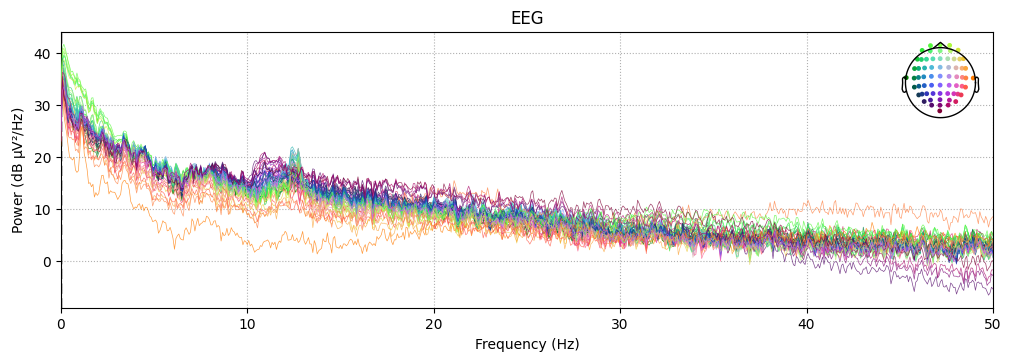

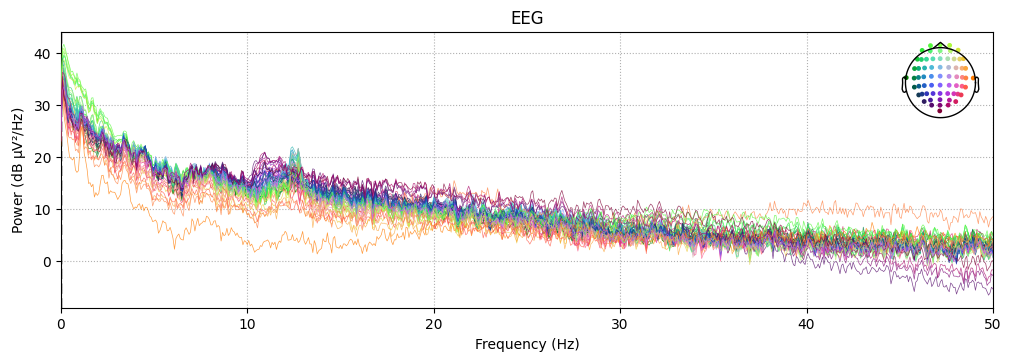

In [ ]:
raw.compute_psd(fmin=0,fmax=50).plot()

Seems like our PSD graph has a negative slope where the strongest frequency is 0 hz.

Our tasks involves two mental states, calmness and motor-related tasks. These states correspond to alpha waves (8-12 hz) and beta waves (13-30 hz), respectively. Since we know our frequencies of interest, we can apply a low-frequency cutoff at 7hz and a high-frequency cutoff at 30hz. Coincidentally, the frequency of electrical outlets falls above our high-frequency cutoff, we don't need to worry about removing them separately.

In [ ]:
f_low = 7
f_high = 30
raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MiB, data loaded>

Let's see what our PSD graph looks like now!

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


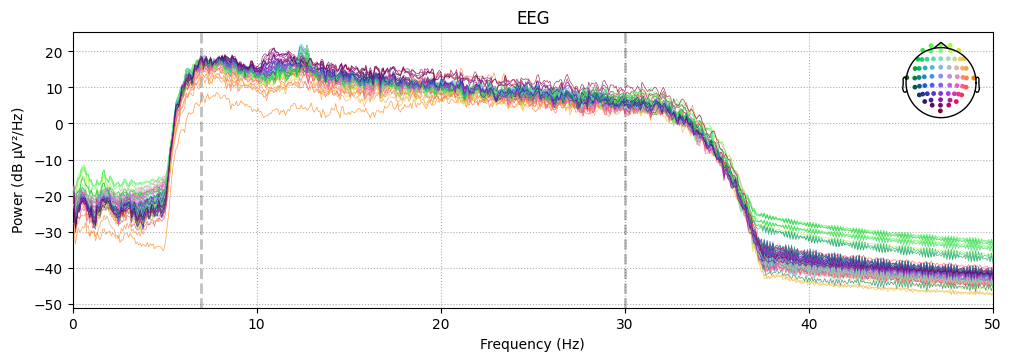

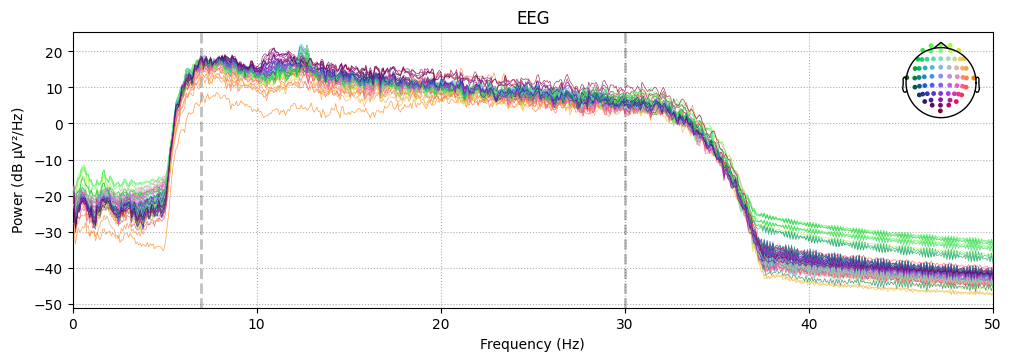

In [ ]:
raw.compute_psd(fmin=0,fmax=50).plot()

We can see that the shape is drastically different, and that the frequencies of interest (7-30 hz) are a lot more pronounced. This means that our band-pass filtering worked, and we can proceed with further pre-processing!

## Selecting Non-Noisy Data

If you read the documentation of our data carefully, you'll have noticed by now that we are working with many types of electrial data, not just EEG. We aren't interested in the rest of the data such as MEG, EOG, STIM, and bad data. Although we can keep pre-processing *everything*, when large amounts of data are involved it is better to cut out unnecessary data.

In [ ]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

You'll notice that we also have an `exclude="bads"` parameter. This does the heavy lifting for us when it comes to determining the quality of signals, and automatically removes the bad ones.

# Conducting artifact removal using ICA

Now that we have our data loaded in and labeled, let's do the first part of artifact removal and do independent component analysis. ICA allows allows us to make a distinction between separate sources of EEG data, such as brain signal, eye blinks, and muscle activity. Once we have our raw wave seperated into different components, we can choose what we want to keep and remove. In our case, we'd keep the components caused by the brain, and remove eye blinks and muscle activity. ICA maintains the interpretability of our data!

In [ ]:
ica = ICA(n_components=8, random_state=97, method="fastica")

ica.fit(raw)

raw_clean = ica.apply(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 3.3s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


Take a look at the function we've used above. A general rule of thumb is to set the `n_components` parameter to equal to however many channels you are using. Keep in mind that this serves as a starting point for figuring out how many components works best for your system.

# Segmenting data via event-based epoching

Now that we have cleaner data, we can create epochs of our data. In our circumstances, it makes more sense to create event-based epochs as opposed to time-based. Take some time to answer why that is the case. Let's make epochs that start one second before our event and end four seconds after

In [ ]:
tmin, tmax = -1.0, 4

event_epochs = Epochs(
    raw_clean,                   # Variable that contains our data
    event_id=["hands", "feet"],  # Events we want to investigate
    tmin=tmin,                   # Start time relative to event
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
45 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


What if we wanted to create time-based epochs? Turns out, we can use the same `Epochs()` method! We just have to get creative and create events at a fixed time interval, which functionally works the same as time based epochings.

In [ ]:
epoch_length = 2.0  # in seconds

events = mne.make_fixed_length_events(raw_clean, id=1, duration=epoch_length)

# Create time-based epochs
time_epochs = mne.Epochs(
    raw_clean,
    events=events,               # Use our generated fixed-time events
    event_id={"fixed_time": 1},  # The id of events to consider for epoching
    tmin=0,                      # Start each epoch from the event onset
    tmax=epoch_length,           # Each epoch lasts 'epoch_length' seconds
    proj=True,                   # Re-reference data if needed
    picks=picks,                 # Use only selected EEG channels
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)

# Print the number of epochs created
print(f"Created {len(time_epochs)} time-based epochs.")


Not setting metadata
187 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 187 events and 321 original time points ...
2 bad epochs dropped
Created 185 time-based epochs.


# Reducing dimensionality using PCA

Now that we have our data nicely set-up in epochs, let's extract some features! We will do this through *Principal-Component Analysis*, which creates new features by using linear combinations of old features. To understand this process, we will see how the shape of our data changes as we apply transformations.

In [ ]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

# Step 1: Get epoch data
X_epochs = event_epochs.get_data()
print(f"Original shape: {X_epochs.shape}")  # Shape: (epochs, channels, times)

Original shape: (45, 64, 801)


The original shape of our data should be (45, 64, 801). This can be interpreted as 45 epochs, each with 64 channels, and each one with 801 samples. Let's do another sanity check: each epoch has five seconds of data sampled at 160 hz, equaling 800 (the extra one is added as a buffer), so this makes sense.

In [ ]:
# Step 2: Apply PCA
n_components = 10
pca_mne = UnsupervisedSpatialFilter(PCA(n_components=n_components), average=False)
X_pca = pca_mne.fit_transform(X_epochs)
print(f"After PCA shape: {X_pca.shape}")  # Shape: (epochs, components, times)

After PCA shape: (45, 10, 801)


If PCA was applied correctly, the new shape of our data should be (45, 10, 801). In summary, this shape represents 45 epochs of data, each summarized by 10 new features (principal components) over 801 time points.

# Preparing data for machine learning

While pre-processing out data, it's important to understand the ultimate goal, which for us is classification. Training machine learning models with many parameters becomes a nightmare and takes forever. To solve this problem, we applied PCA to give us only *10* principal components (aka important features), which will help us train a classifier faster. To further prepare our data for machine learning, we can *flatten* our data to be a 2D shape, which is typically what algorithms expect. Now our shape represents 45 epochs, each summarized by 801 features.

In [ ]:
# Step 3: Reshape data for machine learning
X_flat = X_pca.reshape(X_pca.shape[0], -1)  # Shape: (epochs, components * times)
print(f"Flattened shape: {X_flat.shape}")

Flattened shape: (45, 8010)


# Other Techniques

Boilerplate code for wavelet transform:

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.9s


Applying baseline correction (mode: logratio)


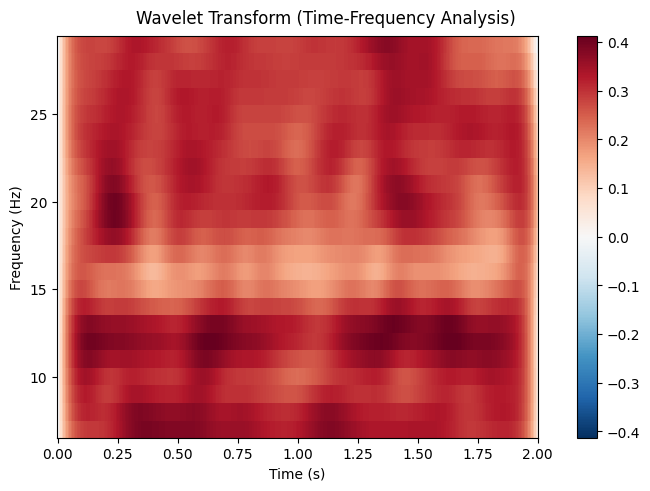

[<Figure size 640x480 with 2 Axes>]

In [ ]:

# Define frequency range (1 to 40 Hz)
freqs = np.arange(7, 30, 1)  # 1 Hz to 40 Hz with 1 Hz steps

# Define number of cycles per frequency (more cycles = better frequency resolution)
n_cycles = freqs / 2  # Example: At 10 Hz, we use 5 cycles

# Compute wavelet transform (TFR)
power, itc = mne.time_frequency.tfr_morlet(
    time_epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True
)

# Plot the time-frequency heatmap for the first EEG channel
power.plot(
    picks=[0],  # Choose first EEG channel
    baseline=(None, 0),  # Normalize power before time 0
    mode='logratio',  # Log-ratio normalization
    title="Wavelet Transform (Time-Frequency Analysis)"
)


#   

---



**EEG Data Analysis Workshop**  
Prepared for **Neurotech@Davis** 2025